### Loading Packages and Defining Functions

In [1]:
from google.colab import drive
import os
import shutil
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

def fast_split_copy(files, source_dir, dest_base_dir):

    total = len(files)
    num_train = int(total * 0.7) #70-15-15 split for the dataset
    num_val   = int(total * 0.15)
    num_test  = total - num_train - num_val

    class_name = os.path.basename(source_dir).replace("breast_", "").capitalize()
    print(f"{class_name}: {num_train} train, {num_val} validation, {num_test} test")

    # Create output dirs once
    for split in ["Train", "Validation", "Test"]:
        folder = os.path.join(dest_base_dir, split, class_name)

        if os.path.exists(folder): # Delete folder if it exists
          shutil.rmtree(folder)
        os.makedirs(folder) #Make fresh folder

    def batch_copy(file_list, split):
        target_dir = os.path.join(dest_base_dir, split, class_name)
        print(f"Copying {class_name} {split} data")
        for f in file_list:
            shutil.copy(os.path.join(source_dir, f), os.path.join(target_dir, f)) # eventually change this to moving data.

    batch_copy(files[:num_train], "Train")
    batch_copy(files[num_train:num_train+num_val], "Validation")
    batch_copy(files[num_train+num_val:], "Test")

# --- Function to copy and replace directory with all subfolders --- #
def copy_dir(src_dir, dst_dir):
  os.makedirs(dst_dir, exist_ok=True)

  for subfolder in os.listdir(src_dir):
    src_subfolder_dir = os.path.join(src_dir, subfolder)
    dst_subfolder_dir = os.path.join(dst_dir, subfolder)

    if os.path.isdir(src_subfolder_dir):
      # Remove destination folder if it exists
      if os.path.exists(dst_subfolder_dir):
        shutil.rmtree(dst_subfolder_dir)

      # Copy source folder to destination (fresh copy)
      shutil.copytree(src_subfolder_dir, dst_subfolder_dir)
      print(f"Copied {src_subfolder_dir} -> {dst_subfolder_dir}")

  print(f"Copied {src_dir} -> {dst_dir}")


# --- Function to augment images in-place ---
def augment(parent_dir, datagen):
  # Count total images in all class subfolders
  num_files = sum(
      len([f for f in os.listdir(os.path.join(parent_dir, c)) if os.path.isfile(os.path.join(parent_dir, c, f))])
      for c in os.listdir(parent_dir)
      if os.path.isdir(os.path.join(parent_dir, c))
      )
  print(f"Total images to augment: {num_files}")

  generator = datagen.flow_from_directory(
      directory=parent_dir,    # parent folder containing subfolders
      target_size=(224, 224),
      batch_size=1,
      class_mode='binary',
      save_to_dir=None,        # keeps augmented images in their subfolders
      save_format='jpeg'
  )

  # Generate one augmented image per original
  for i, _ in enumerate(generator):
      if i >= num_files:
          break


# --- Function to combine augmented and original data --- #
# --- It rename files in destination directory's subfolders and then
# copy and merge corresponding subfolders from the source directory --- #
def combine(src_dir, dst_dir, renamed_dst_dir, specifier="aug"):
    """
    Rename existing files in dst_dir by prepending a specifier,
    then copy all files from src_dir into dst_dir with their original names.

    Example:
        Existing file in dst_dir: image1.jpg -> aug_image1.jpg
        File from src_dir copied: image2.jpg -> image2.jpg
    """

    def count_files(directory):
        total = 0
        for subfolder in os.listdir(directory):
            subfolder_path = os.path.join(directory, subfolder)
            if os.path.isdir(subfolder_path):
                total += sum(1 for f in os.listdir(subfolder_path)
                             if os.path.isfile(os.path.join(subfolder_path, f)))
        return total

    # Count files before copying
    total_src_files = count_files(src_dir)
    total_dst_files = count_files(dst_dir)
    print(f"Total files in src_dir before copying: {total_src_files}")
    print(f"Total files in dst_dir before copying: {total_dst_files}")

    # Loop over all subfolders
    for subfolder in os.listdir(src_dir):
        src_subfolder_dir = os.path.join(src_dir, subfolder)
        dst_subfolder_dir = os.path.join(dst_dir, subfolder)

        if os.path.isdir(src_subfolder_dir) and os.path.isdir(dst_subfolder_dir):
            # 1️⃣ Rename all existing files in dst_subfolder_dir
            for f in os.listdir(dst_subfolder_dir):
                dst_file = os.path.join(dst_subfolder_dir, f)
                if os.path.isfile(dst_file):
                    new_name = f"{specifier}_{f}"
                    new_path = os.path.join(dst_subfolder_dir, new_name)
                    os.rename(dst_file, new_path)
                    #print(f"Renamed {dst_file} -> {new_path}")

            # 2️⃣ Copy all files from src_subfolder_dir to dst_subfolder_dir
            for f in os.listdir(src_subfolder_dir):
                src_file = os.path.join(src_subfolder_dir, f)
                dst_file = os.path.join(dst_subfolder_dir, f)  # keep original name
                if os.path.isfile(src_file):
                    shutil.copy2(src_file, dst_file)
                    #print(f"Copied {src_file} -> {dst_file}")

    print(f"Finished renaming existing files in {dst_dir} and copying new files from {src_dir}.")

    # Count files after copying
    total_dst_after = count_files(dst_dir)
    print(f"Total files in dst_dir after copying: {total_dst_after}")

    if os.path.exists(renamed_dst_dir):
        shutil.rmtree(renamed_dst_dir)
        print(f"Removed existing {renamed_dst_dir}")

    # Rename source to target
    os.rename(dst_dir, renamed_dst_dir)
    print(f"Renamed {dst_dir} -> {renamed_dst_dir}")


def condition_data(base_dir, folder_name, mode="comb"):
    """
    Process a dataset folder (Train, Test, Validate):
      1. Copy original data to an *_Aug folder.
      2. Augment images in *_Aug folder.
      3. Combine original and augmented data into *_Comb folder with renaming to avoid collisions.

    Args:
        base_dir (str): Base directory containing the folder.
        folder_name (str): One of "Train", "Test", "Validate".
        mode (str): "comb" or "aug" specifies whether to run on
                    augmented/ combined (original + augmented) data.
    """
    drive.mount('/content/drive', force_remount=True) # Needs this, otherwise it looses the Google Drive

    # Original and augmented directories
    orig_dir = os.path.join(base_dir, folder_name)
    aug_dir = os.path.join(base_dir, f"{folder_name}_Aug")
    comb_dir = os.path.join(base_dir, f"{folder_name}_Comb")

    # 1️⃣ Copy original folder to *_Aug
    copy_dir(orig_dir, aug_dir)

    # 2️⃣ Initialize ImageDataGenerator
    datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.2,
                                 horizontal_flip=True,
                                 brightness_range=[0.8, 1.2], rescale=1./255)

    # 3️⃣ Augment images in *_Aug folder
    augment(aug_dir, datagen)

    if(mode=="comb"):
      # 4️⃣ Combine original and augmented data into *_Comb
      specifier="aug" #Prefix to add to original files when combining to avoid collisions.
      combine(orig_dir, aug_dir, comb_dir, specifier)

    print(f"Completed processing for {folder_name}\n")

def load_generator(directory, target_size=(224, 224), rescale=1./255):
    datagen = ImageDataGenerator(rescale=rescale)
    batch_size=32 # Do not change unless you're changing the layers in the model itself

    return datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary'
    )

### Configurations

In [2]:
#Configs
move = 0 # Only change this if you're copying the original data into sub-folders.

condition = 0 # Only change if you're conditioning the data copied into subfolders.
mode = "comb" # Options "comb" or "aug" specify whether to run on augmented/ combined (original + augmented) data.

train_model = 0

drive.mount('/content/drive', force_remount=True)
base_dir = "drive/My Drive/Breast Cancer"

Mounted at /content/drive


### Move Data in Subfolders (if move==1)

In [3]:
# Moving original data into subfolders - only needs to be done once
if(move==1):
  # Base directory of your dataset
  base_dir = "drive/My Drive/Breast Cancer"
  benign_dir = base_dir + "/breast_benign"
  malignant_dir = base_dir + "/breast_malignant"

  # Number of total benign and malignmant images for memory allocation
  Nb = len(os.listdir(benign_dir))
  Nm = len(os.listdir(malignant_dir))
  print(f"Total benign images in source = {Nb}\n")
  print(f"Total malignant images in source = {Nm}\n")

  #Allocate memory for numpy arrays.
  benign_images = np.empty(Nb, dtype=object)
  malignant_images = np.empty(Nm, dtype=object)

  #Names of image files in benign and malignant directories in numpy arrays.
  i = 0
  for f in sorted(os.listdir(benign_dir)):
      if os.path.isfile(os.path.join(benign_dir, f)): #check if f is a file and not a folder/directory
          benign_images[i] = f
          i += 1
  i = 0
  for f in sorted(os.listdir(malignant_dir)):
      if os.path.isfile(os.path.join(malignant_dir, f)): #check if f is a file and not a folder/directory
          malignant_images[i] = f
          i += 1

  # Split and move images
  fast_split_copy(benign_images, benign_dir, base_dir)
  fast_split_copy(malignant_images, malignant_dir, base_dir)

  move = 0;

### Condition Images (if condition==1):
1.   Resize and Normalize
2.   Combine original and Augmented Datasets



Images resized to a uniform dimension of 224x224 pixels. The pixel values are normalized to a floating-point range of 0 to 1.

In [4]:
if(condition==1):
  condition_data(base_dir, "Train", mode=mode)
  condition_data(base_dir, "Test", mode=mode)
  condition_data(base_dir, "Validation", mode=mode)

  condition = 0;

###Model & layers

In [5]:
if(train_model==1):
  # Initialize the Sequential model
  model = Sequential()

  # Add the first Convolutional Block
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.25))

  # Add the second Convolutional Block
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.25))

  # Add the third Convolutional Block
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.25))

  # Flatten the output for Dense layers
  model.add(Flatten())

  # Add Dense layers
  model.add(Dense(256, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  # Output layer for binary classification
  model.add(Dense(1, activation='sigmoid'))

  # Print the model summary to verify the architecture
  model.summary()

  model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

### Train and Save the Model (if train_model==1)

In [6]:
if(train_model==1):

  train = os.path.join(base_dir, "Train_Comb")
  valid = os.path.join(base_dir, "Validation_Comb")
  test = os.path.join(base_dir, "Test_Comb")

  # Can specify target size (duple) and rescaling here.
  # Batch size is fixed to 32 - consistent with the layers in the model
  # Default target_size=(224, 224), rescale=1./255
  train_generator = load_generator(train)
  validation_generator = load_generator(valid)
  test_generator = load_generator(test)
  test_generator.shuffle = False # keras defaults to True

  # Checkpoint paths
  checkpoint_path = f"{base_dir}/model_checkpoint.keras"
  epoch_log_path  = f"{base_dir}/epoch_log.txt"
  metrics_log_path = f"{base_dir}/metrics.txt" # Logs epoch number, accuracy and loss

  # Check for checkpoint and progress log
  initial_epoch = 0
  if os.path.exists(checkpoint_path):
      print("Checkpoint found — resuming training...")
      model.load_weights(checkpoint_path)

      if os.path.exists(epoch_log_path):
          with open(epoch_log_path, "r") as f:
              initial_epoch = int(f.read().strip())
          print(f"Resuming from epoch {initial_epoch+1}")

  else:
      print("No checkpoint found — starting fresh.")
      if os.path.exists(metrics_log_path):
        os.remove(metrics_log_path)

  # log completed epoch number + checkpoint after each completed epoch (saved in Drive)
  class EpochLogger(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs=None):
          with open(epoch_log_path, "w") as f:
              f.write(str(epoch+1))   # log next start epoch

  class MetricsLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        mode = "a" if os.path.exists(metrics_log_path) else "w"
        with open(metrics_log_path, mode) as f:
            f.write(f"{epoch+1}\t{logs['accuracy']:.6f}\t{logs['loss']:.6f}\n")

  checkpoint = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_path,
      monitor="val_loss",
      save_best_only=False,   # must be False to save each epoch
      save_weights_only=False,
      verbose=1
  )

  # Resume-safe training
  history = model.fit(train_generator, validation_data=validation_generator,
      epochs=30, initial_epoch=initial_epoch, callbacks=[checkpoint, EpochLogger(), MetricsLogger()])

  model.save(f"{base_dir}/final_model.keras")          # entire model + weights
  #model.save_weights(f"{base_dir}/final.weights.h5") # just weights (optional)

  train_model = 0;

###Plot Training Metrics

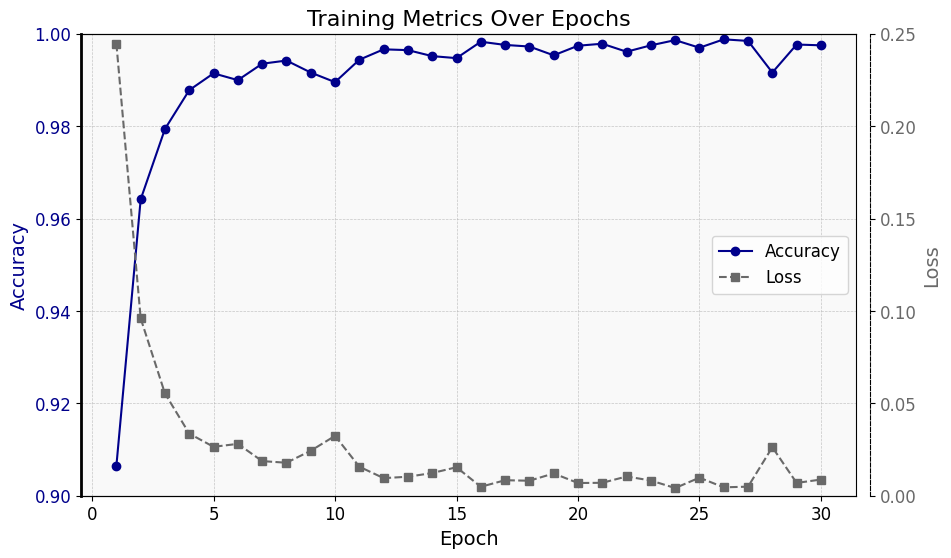

In [28]:
# Path to your metrics file
metrics_log_path = f"{base_dir}/metrics.txt"

# Load metrics.txt (tab separated: epoch, accuracy, loss)
metrics = np.loadtxt(metrics_log_path, delimiter="\t")

epochs = metrics[:, 0]
accuracy = metrics[:, 1]
loss = metrics[:, 2]

# Font sizes
title_fontsize = 16
label_fontsize = 14
tick_fontsize = 12
legend_fontsize = 12

# Create figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# ---- Left axis: Accuracy ----
ax1.plot(epochs, accuracy, marker='o', linestyle='-', color='darkblue', label='Accuracy')
ax1.set_xlabel("Epoch", fontsize=label_fontsize)
ax1.set_ylabel("Accuracy", color='darkblue', fontsize=label_fontsize)
ax1.tick_params(axis='y', labelcolor='darkblue', labelsize=tick_fontsize)
ax1.tick_params(axis='x', labelsize=tick_fontsize)
ax1.set_ylim(0.9, 1.0)
ax1.spines['left'].set_linewidth(2)
ax1.set_facecolor('#f9f9f9')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# ---- Right axis: Loss ----
ax2 = ax1.twinx()
ax2.plot(epochs, loss, marker='s', linestyle='--', color='dimgray', label='Loss')
ax2.set_ylabel("Loss", color='dimgray', fontsize=label_fontsize)
ax2.tick_params(axis='y', labelcolor='dimgray', labelsize=tick_fontsize)
ax2.set_ylim(0, 0.25)
ax2.spines['right'].set_position(('outward', 10))
ax2.spines['right'].set_linestyle('--')
ax2.set_facecolor('#f9f9f9')
ax2.grid(False)  # Prevent double gridlines

# ---- Title and legends ----
plt.title("Training Metrics Over Epochs", fontsize=title_fontsize)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='center right', fontsize=legend_fontsize)

#plt.savefig(f"{base_dir}/training_metrics.png", dpi=300, bbox_inches="tight")
plt.show()


## Evaluate Model on Test Data

Evaluate the trained model on the test dataset located in `drive/My Drive/Breast Cancer/Test` and display the test loss and accuracy.

In [7]:
# Load trained model
loaded = tf.keras.models.load_model(f"{base_dir}/final_model.keras")

test = os.path.join(base_dir, "Test_Comb")
test_generator = load_generator(test)

# Evaluate model over complete test dataset
test_loss, test_accuracy = loaded.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Found 2478 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


78/78 ━━━━━━━━━━━━━━━━━━━━ 932s 12s/step - accuracy: 0.9539 - loss: 0.1979
Test Loss: 0.1842
Test Accuracy: 0.9532


In [20]:
# ---- Plot evaluation for 10 random test samples ----
num_samples = 10
indices = random.sample(range(len(test_generator.filenames)), num_samples)

class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(18, 9.5))

for i, idx in enumerate(indices):
    img_path = test_generator.filepaths[idx]

    # Load + preprocess
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=test_generator.target_size)
    img_arr = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_arr = np.expand_dims(img_arr, axis=0)

    # Prediction
    pred = loaded.predict(img_arr, verbose=0)
    prob_malignant = float(pred[0][0])
    pred_label = "Malignant" if prob_malignant >= 0.5 else "Benign"

    # True label
    true_class_index = test_generator.classes[idx]
    true_label = class_names[true_class_index]

    # Display
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    title_color = "green" if pred_label == true_label else "red"

    plt.title(f"True: {true_label}\nPredicted: {pred_label}", color=title_color, fontsize=20)
    plt.axis("off")

plt.tight_layout(rect=[0, 0.02, 1, 1])

plt.figtext(0.5, 0.015, f"Aggregate Test Metrics: Loss {test_loss:.4f} | Accuracy: {test_accuracy:.4f}",
            ha="center", fontsize=20)

#plt.savefig(f"{base_dir}/random_test_results.png", dpi=300, bbox_inches="tight")
plt.show()

Output hidden; open in https://colab.research.google.com to view.